# Import Statements

In [732]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# carry out one hot encoding
from feature_engine.encoding import OneHotEncoder

# Import Scalers
# for min-max scaling
from sklearn.preprocessing import MinMaxScaler
# for standardization
from sklearn.preprocessing import StandardScaler
# for robust scaling
from sklearn.preprocessing import RobustScaler

# import XGBRegressor from xgboost package
from xgboost import XGBRegressor

# to evaluate model metrics
from sklearn.metrics import mean_squared_error, r2_score

# import grid search cv to improve decision tree model by helping search for parameters
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session

# to export model
import joblib

# Functions

In [733]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [734]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [735]:
# retrieve order details usa table from snowflake
order_data_from_snowflake = session.table("frostbyte_tasty_bytes.analytics.ORDER_DETAILS_USA_MATCHED")

In [736]:
# convert order_data_from_snowflake to pandas dataframe
order_df = order_data_from_snowflake.to_pandas()

In [737]:
# # Get the total quantity sold for each menu item 
# ## group by 'MENU_ITEM_ID' and calculate the total quantity sold
# total_qty_sold_per_item = order_df.groupby('MENU_ITEM_ID')['QUANTITY'].sum().reset_index()

# ## rename the 'QUANTITY' column to 'TOTAL_QTY_SOLD'
# total_qty_sold_per_item = total_qty_sold_per_item.rename(columns={'QUANTITY': 'TOTAL_QTY_SOLD'})

In [738]:
order_df.head()

,ORDER_ID,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,SHIFT_ID,SHIFT_START_TIME,SHIFT_END_TIME,ORDER_CHANNEL,ORDER_TS,SERVED_TS,...,E_MAIL,PHONE_NUMBER,ORDER_DETAIL_ID,MENU_ITEM_ID,DISCOUNT_ID,LINE_NUMBER,QUANTITY,UNIT_PRICE,PRICE,ORDER_ITEM_DISCOUNT_AMOUNT
0,458794375,156760,58,15265.0,200579403,16:00:00,23:00:00,None,2022-06-25 20:41:53,None,...,Leonard.Gray@gmail.com,625-940-1708,902773092,132,None,0,1,11.0,11.0,None
1,458794375,156760,58,15265.0,200579403,16:00:00,23:00:00,None,2022-06-25 20:41:53,None,...,Leonard.Gray@gmail.com,625-940-1708,902773093,133,None,1,2,6.0,12.0,None
2,458945343,122545,55,3736.0,200580206,08:30:00,14:30:00,None,2022-07-22 12:03:29,None,...,Charles.Lloyd@gmail.com,084-800-3467,903182637,106,None,0,2,3.0,6.0,None
3,458945343,122545,55,3736.0,200580206,08:30:00,14:30:00,None,2022-07-22 12:03:29,None,...,Charles.Lloyd@gmail.com,084-800-3467,903182638,102,None,1,3,9.0,27.0,None
4,458945343,122545,55,3736.0,200580206,08:30:00,14:30:00,None,2022-07-22 12:03:29,None,...,Charles.Lloyd@gmail.com,084-800-3467,903182639,103,None,2,1,10.0,10.0,None


In [739]:
order_df = order_df[["MENU_ITEM_ID", "ORDER_TS", "QUANTITY"]]
order_df.head()

,MENU_ITEM_ID,ORDER_TS,QUANTITY
0,132,2022-06-25 20:41:53,1
1,133,2022-06-25 20:41:53,2
2,106,2022-07-22 12:03:29,2
3,102,2022-07-22 12:03:29,3
4,103,2022-07-22 12:03:29,1


In [740]:
order_df['YEAR'] = order_df['ORDER_TS'].dt.year
order_df['MONTH'] = order_df['ORDER_TS'].dt.month
order_df.head()

,MENU_ITEM_ID,ORDER_TS,QUANTITY,YEAR,MONTH
0,132,2022-06-25 20:41:53,1,2022,6
1,133,2022-06-25 20:41:53,2,2022,6
2,106,2022-07-22 12:03:29,2,2022,7
3,102,2022-07-22 12:03:29,3,2022,7
4,103,2022-07-22 12:03:29,1,2022,7


In [741]:
# Group order total to truck id
total_qty_by_item = order_df.groupby(['YEAR', 'MONTH', 'MENU_ITEM_ID'])['QUANTITY'].sum().reset_index()

# Renaming the 'ORDER_TOTAL' column to 'TOTAL_SALES_PER_MONTH'
total_qty_by_item = total_qty_by_item.rename(columns={'QUANTITY': 'TOTAL_QTY_SOLD_PER_MONTH'})

# View the data
total_qty_by_item

,YEAR,MONTH,MENU_ITEM_ID,TOTAL_QTY_SOLD_PER_MONTH
0,2022,6,42,1
1,2022,6,43,1
2,2022,6,51,1
3,2022,6,52,1
4,2022,6,53,1
...,...,...,...,...
473,2022,11,152,232
474,2022,11,153,245
475,2022,11,154,60
476,2022,11,155,52


# Menu Table 

In [742]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU")

In [743]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = menu_data_from_snowflake.to_pandas()

In [744]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, total_qty_by_item, on='MENU_ITEM_ID')

In [745]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,YEAR,MONTH,TOTAL_QTY_SOLD_PER_MONTH
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,8,11
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,9,46
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,10,509
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,11,41
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,7,5


In [746]:
# Convert the string JSON data to a nested dictionary
menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'] = menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'].apply(ast.literal_eval)

# Use json_normalize to flatten the nested JSON data
menu_item_metrics = pd.json_normalize(menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'], record_path='menu_item_health_metrics')

# Rename the columns
menu_item_metrics = menu_item_metrics.rename(columns={
    'is_dairy_free_flag': 'DAIRY_FREE',
    'is_gluten_free_flag': 'GLUTEN_FREE',
    'is_healthy_flag': 'HEALTHY',
    'is_nut_free_flag': 'NUT_FREE'
})

# Replace 'Y' with 'Yes' and 'N' with 'No' in the DataFrame
menu_item_metrics = menu_item_metrics.replace({'Y': 1, 'N': 0})

# Concatenate the flattened DataFrame with the original DataFrame
menu_df = pd.concat([menu_df, menu_item_metrics], axis=1)

# Drop the original 'MENU_ITEM_HEALTH_METRICS_OBJ' and 'ingredients' column 
menu_df = menu_df.drop(columns=['MENU_ITEM_HEALTH_METRICS_OBJ', 'ingredients'])

In [747]:
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,MONTH,TOTAL_QTY_SOLD_PER_MONTH,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,8,11,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,9,46,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,10,509,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,11,41,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2022,7,5,1,1,0,1


# Final Table

In [748]:
final_df = menu_df

In [749]:
final_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,MONTH,TOTAL_QTY_SOLD_PER_MONTH,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,8,11,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,9,46,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,10,509,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,11,41,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2022,7,5,1,1,0,1


In [750]:
final_df['TOTAL_QTY_SOLD_PER_MONTH'] = final_df['TOTAL_QTY_SOLD_PER_MONTH'].astype(int)

In [751]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_QTY_SOLD_PER_MONTH'].min()
max_value = final_df['TOTAL_QTY_SOLD_PER_MONTH'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 1 - 3323


In [752]:
final_df = final_df.drop(["COST_OF_GOODS_USD", "MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_NAME"], axis=1)
final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,MONTH,TOTAL_QTY_SOLD_PER_MONTH,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2022,8,11,1,1,0,1
1,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2022,9,46,1,1,0,1
2,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2022,10,509,1,1,0,1
3,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2022,11,41,1,1,0,1
4,Ice Cream,Freezing Point,11,Dessert,Cold Option,6.0,2022,7,5,1,1,0,1


# Check for Missing Values

In [753]:
final_df.isnull().sum()

MENU_TYPE                   0
TRUCK_BRAND_NAME            0
MENU_ITEM_ID                0
ITEM_CATEGORY               0
ITEM_SUBCATEGORY            0
SALE_PRICE_USD              0
YEAR                        0
MONTH                       0
TOTAL_QTY_SOLD_PER_MONTH    0
DAIRY_FREE                  0
GLUTEN_FREE                 0
HEALTHY                     0
NUT_FREE                    0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

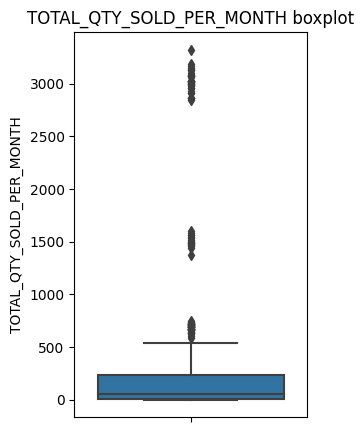

In [754]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD_PER_MONTH'])
plt.title('TOTAL_QTY_SOLD_PER_MONTH boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [755]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD_PER_MONTH', axis=1), final_df['TOTAL_QTY_SOLD_PER_MONTH'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((334, 12), (144, 12))

# Categorical Variable Encoding 

In [756]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [757]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode

ohe_enc.fit(X_train)

c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consisten

OneHotEncoder(drop_last=True)

In [758]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [759]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [760]:
# Save the model to a file
joblib.dump(scaler, "StreamlitApp/assets/product_qty_per_month_min_max_scaler.joblib")

['StreamlitApp/assets/product_qty_per_month_min_max_scaler.joblib']

## Standard Scaler

In [761]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [762]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [763]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Model

In [764]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  124.94784018619468
the testing root mean squared error is:  160.82096857035046

the training mean squared error is:  15611.962767194846
the testing mean squared error is:  25863.383931905653

training accuracy is:  0.9765978591054263
testing accuracy is:  0.9610947005142787


# Improve Model (GridSearch CV)

In [765]:
param_grid = {'n_estimators': [10, 20, 30],
              'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [3,4,5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 30}
Best score found:  0.994233352187881


# Improved Model Results

In [766]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.2, max_depth = 4, n_estimators = 30)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  21.5241869229418
the testing root mean squared error is:  74.91592150287438

the training mean squared error is:  463.29062269373884
the testing mean squared error is:  5612.395294624836

training accuracy is:  0.9993055330332842
testing accuracy is:  0.9915574883648436


In [767]:
xgb_improved.feature_importances_

array([4.7154907e-02, 3.4937558e-01, 0.0000000e+00, 4.3084031e-01,
       6.2406098e-04, 3.8913547e-04, 1.5287993e-04, 6.1196799e-05,
       2.2070668e-05, 9.1970534e-05, 1.0199338e-04, 1.1314918e-04,
       5.1437761e-04, 2.4122465e-04, 0.0000000e+00, 1.0658968e-05,
       3.5314047e-04, 6.1211141e-04, 2.8178998e-05, 1.2166712e-05,
       6.1127095e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.6741997e-01, 8.7335252e-04, 3.9627741e-04, 0.0000000e+00,
       0.0000000e+00], dtype=float32)

In [768]:
# Get the feature importances
feature_importance = xgb_improved.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                                  Feature  Importance
3                                   MONTH    0.430840
1                          SALE_PRICE_USD    0.349376
36                 ITEM_CATEGORY_Beverage    0.167420
0                            MENU_ITEM_ID    0.047155
37                     ITEM_CATEGORY_Main    0.000873
4                              DAIRY_FREE    0.000624
17                     MENU_TYPE_Hot Dogs    0.000612
20                       MENU_TYPE_Crepes    0.000611
12                    MENU_TYPE_Ethiopian    0.000514
38                    ITEM_CATEGORY_Snack    0.000396
5                             GLUTEN_FREE    0.000389
16                        MENU_TYPE_Gyros    0.000353
13                 MENU_TYPE_Mac & Cheese    0.000241
6                                 HEALTHY    0.000153
11                      MENU_TYPE_Poutine    0.000113
10               MENU_TYPE_Grilled Cheese    0.000102
9                         MENU_TYPE_Ramen    0.000092
7                           

In [769]:
X_train.head()

,MENU_ITEM_ID,SALE_PRICE_USD,YEAR,MONTH,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE,MENU_TYPE_BBQ,MENU_TYPE_Ramen,...,TRUCK_BRAND_NAME_Amped Up Franks,TRUCK_BRAND_NAME_Guac n' Roll,TRUCK_BRAND_NAME_Peking Truck,TRUCK_BRAND_NAME_Le Coin des Crêpes,TRUCK_BRAND_NAME_Freezing Point,ITEM_CATEGORY_Beverage,ITEM_CATEGORY_Main,ITEM_CATEGORY_Snack,ITEM_SUBCATEGORY_Cold Option,ITEM_SUBCATEGORY_Hot Option
64,25,3.00,2022,9,1,1,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
159,51,17.25,2022,10,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
208,65,3.00,2022,11,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
81,29,6.00,2022,7,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
344,113,14.00,2022,11,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [770]:
X_train.columns

Index(['MENU_ITEM_ID', 'SALE_PRICE_USD', 'YEAR', 'MONTH', 'DAIRY_FREE',
       'GLUTEN_FREE', 'HEALTHY', 'NUT_FREE', 'MENU_TYPE_BBQ',
       'MENU_TYPE_Ramen', 'MENU_TYPE_Grilled Cheese', 'MENU_TYPE_Poutine',
       'MENU_TYPE_Ethiopian', 'MENU_TYPE_Mac & Cheese', 'MENU_TYPE_Sandwiches',
       'MENU_TYPE_Indian', 'MENU_TYPE_Gyros', 'MENU_TYPE_Hot Dogs',
       'MENU_TYPE_Tacos', 'MENU_TYPE_Chinese', 'MENU_TYPE_Crepes',
       'MENU_TYPE_Ice Cream', 'TRUCK_BRAND_NAME_Smoky BBQ',
       'TRUCK_BRAND_NAME_Kitakata Ramen Bar', 'TRUCK_BRAND_NAME_The Mega Melt',
       'TRUCK_BRAND_NAME_Revenge of the Curds', 'TRUCK_BRAND_NAME_Tasty Tibs',
       'TRUCK_BRAND_NAME_The Mac Shack', 'TRUCK_BRAND_NAME_Better Off Bread',
       'TRUCK_BRAND_NAME_Nani's Kitchen', 'TRUCK_BRAND_NAME_Cheeky Greek',
       'TRUCK_BRAND_NAME_Amped Up Franks', 'TRUCK_BRAND_NAME_Guac n' Roll',
       'TRUCK_BRAND_NAME_Peking Truck', 'TRUCK_BRAND_NAME_Le Coin des Crêpes',
       'TRUCK_BRAND_NAME_Freezing Point', 'ITEM_C